In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy

In [2]:
# select the data file to load
#dfile = os.path.join(DATA_PATH, 'FlatSpecEoR_Jy_SEED001.uvh5')
#dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
#dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)
#uvd.get_antpairs()

In [3]:
cosmo = hp.conversions.Cosmo_Conversions()
print(cosmo)
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
#beam_freqs = np.linspace(0, 384e6, 384)
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
#uvb = hp.PSpecBeamGauss(fwhm=0.1, beam_freqs=beam_freqs)

Cosmo_Conversions object at <0x7f872b0439d0>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [4]:
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [5]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [17]:
# Specify which baselines to include
baselines = [(1,121)]
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True,exclude_permutations=True)
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(800,1000)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=True)

#uvp = ds.pspec(baselines1, baselines2, (0, 1), [('pI', 'pI')], spw_ranges=[(100,200)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (800, 1000)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((1, 121), (1, 121))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [8]:
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm, kstest
def plot_kstest(x, data, x_delay=False, alpha=0.05):
    """
    H0: dist1 = dist2
    d < critical value, p-value > alpha -->> accept H0
    ------
    x: 1d array (time, delay mode)
    data: 2d array (visibility, power)
    x_delay: is x axis delay? (default: False)
    alpha: significance level (default: 0.05)
    ------
    Data matrix rows -->> time sample
    Data matrix columns -->> frequency/delay mode
    """
    
    if x_delay:
        data = np.transpose(data)
    
    # fit each dataset with a normal distribution
    mu = []
    std = []
    for i in range(len(data)):
        mu.append(norm.fit(data[i])[0])
        std.append(norm.fit(data[i])[1])
        
    # get cdf of each dataset
    cdf = []
    for i in range(len(data)):
        cdf.append(np.array(range(len(data[i])))/float(len(data[i])))
    
    # get cdf of each fit
    norm_cdf = []
    for i in range(len(data)):
        norm_cdf.append(norm.cdf(np.sort(data[i]), mu[i], std[i]))
    
    # perform KS test between each empirical dataset with its corresponding normal distribution
    # get d (KS statistic) and p-values
    d = []
    p = []
    for i in range(len(data)):
        d.append(stats.ks_2samp(cdf[i], norm_cdf[i])[0])
        p.append(stats.ks_2samp(cdf[i], norm_cdf[i])[1])
    
    # get critical value (significance level = 0.05) (by the AD-test function)
    cv = []
    for i in range(len(data)):
        cv.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1][2])
    
    # plot cdf if the number of datasets is small
    #if len(data) < 16:
        #plt.figure(figsize=(12, 12))
        #for i in range(1, len(cv)+1):
            #plt.subplot(6, 4, i)
            #i -= 1
            #plt.plot(np.sort(data[i]), norm_cdf[i],'b--')
            #plt.plot(np.sort(data[i]), cdf[i], 'r-')
            #plt.grid()
    
    # plot KS test results
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot
    ax.plot(x, d, 'r-', label='KS statistics')
    ax.plot
    ax.plot(x, cv, 'b--', label='Critical values')
    ax.grid()
    ax.legend()
    
    plt.subplot(2, 1, 1)
    plt.plot(x, [alpha for i in range(len(x))], 'k--', label='Significance level')
    plt.plot(x, p, 'g-', label="p values")
    plt.legend()
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(x, cv, 'b--', label='Critical values')
    plt.plot(x, d, 'r-', label='KS statistics')
    plt.legend()
    plt.grid()
    plt.show()

Choose spectral window by index. Available spw are : [(178125000.0, 197656250.0, 200, 200)]
0
Choose baseline pair by index. Available blp are : [((1, 121), (1, 121))]
0
How many ranges of delays to split equally?
10
All delay ranges : [(-5120, -3988), (-3988, -2856), (-2856, -1724), (-1724, -592), (-592, 540), (540, 1672), (1672, 2804), (2804, 3936), (3936, 5068), (-5120, 5068)]
At what range of time would you like to select powers?
Minimum time : 
0
Maximum time : 
29
10


p-value floored: true value smaller than 0.001


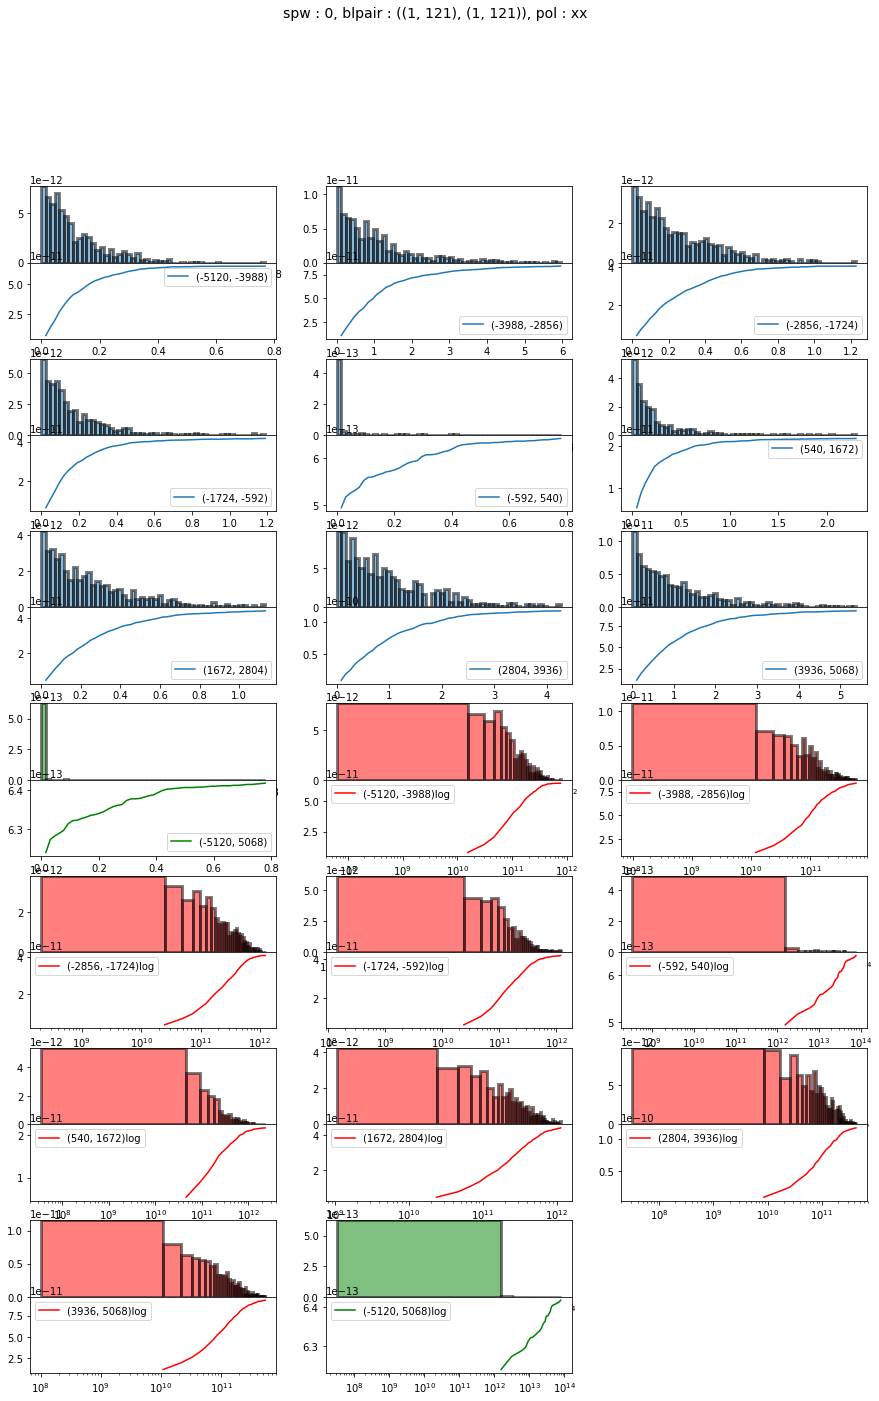

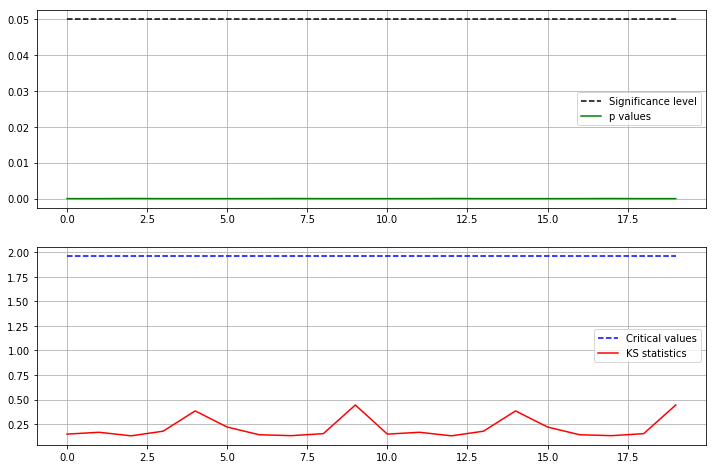

In [18]:
import matplotlib.gridspec as gridspec
blpairs=uvp.get_blpairs()
print("Choose spectral window by index. Available spw are : " + str(uvp.get_spw_ranges()))
spw = input()
print("Choose baseline pair by index. Available blp are : " + str(uvp.get_blpairs()))
blp_choice = input()
blp =blpairs[blp_choice]

dlys = uvp.get_dlys(spw) * 1e9

print("How many ranges of delays to split equally?")
#print("Total delay is " + str(np.amax(dlys) + " :"))
num_intervals = input()
intervals = np.linspace(int(min(dlys)),int(max(dlys)),num_intervals)

dlys_ranges=[]
for i in range(0,num_intervals-1):
    dlys_ranges.append((int(intervals[i]),int(intervals[i+1])))

dlys_ranges.append((int(min(intervals)),int(max(intervals))))

print("All delay ranges : " + str(dlys_ranges))

fig = plt.figure(constrained_layout=False)


#We will store the histogram values to plot the cdf
cdf=[]
c=0
r=0
num_rows = int(2*len(dlys_ranges)/3)+2

gs = gridspec.GridSpec(num_rows,3)
gs.update(wspace=0.2, hspace=0.13)

print("At what range of time would you like to select powers?")
print("Minimum time : ")
min_time = input()
print("Maximum time : ")
max_time = input()

data_array=[]

key = (spw, blp, 'xx')

power = np.abs(np.real(uvp.get_data(key)))
print(len(dlys_ranges))
for k in range(0,2):
    
    for j in range(0,len(dlys_ranges)):

        min_dlys = dlys_ranges[j][0]
        max_dlys = dlys_ranges[j][1]
        
        closest_min_delay = min(dlys, key=lambda x:abs(x-min_dlys))
        closest_max_delay = min(dlys, key=lambda x:abs(x-max_dlys))
    
        min_delay_index = np.where(dlys==closest_min_delay)
        max_delay_index = np.where(dlys==closest_max_delay)
        
        data=power.T[min_delay_index[0][0]:max_delay_index[0][0]][:,min_time:max_time].flatten()
        
        data_array.append(data)
        #print(data)
        if c==3:
            c=0
            r=r+1

        gss01 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[j+len(dlys_ranges)*k],hspace=0.0)
        #gss02 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[j+len(dlys_ranges)*k],hspace=0.0)

        ax0 = fig.add_subplot(gss01[0])
        ax1 = fig.add_subplot(gss01[1], sharex=ax0)
        if k == 0:
            if j == len(dlys_ranges)-1:
                col='g'
            else:
                col='#1f77b4'
            lab=str(dlys_ranges[j])
        else:
            lab=str(dlys_ranges[j]) + "log"
            ax0.set_xscale('log')
            ax1.set_xscale('log')
            if j == len(dlys_ranges)-1:
                col='g'
            else:
                col='r'
        
        p=ax0.hist(data,alpha=0.5,bins=50,density=True,linewidth=3,edgecolor='k',label=lab,color=col)
        
        #ax00 = fig.add_subplot(gss01[0])
        #ax11 = fig.add_subplot(gss01[1], sharex=ax0)
        cdf_sum = np.cumsum(p[0]) # calculate the cdf
        #mu = norm.fit(data)[0]
        #std = norm.fit(data)[1]
        #norm_cdf = norm.cdf(np.sort(data), mu, std)
        
        #d = stats.ks_2samp(cdf_sum, norm_cdf)[0]
        #p = stats.ks_2samp(cdf_sum, norm_cdf)[1]
        #cv = stats.anderson_ksamp([cdf_sum, norm_cdf])[1][2]
        #ax00.plot(x, d, 'r-', label='KS statistics')
        #ax00.plot(x, cv, 'b--', label='Critical values')
        #ax11.plot(x, alpha, 'k--', label='Significance level')
        #ax11.plot(x, p, 'g-', label="p values")
    
        ax1.plot(p[1][1:],cdf_sum,alpha=1,label=lab,color=col)
        ax1.legend()   
        c=c+1
fig.suptitle("spw : {}, blpair : {}, pol : {}".format(*key),fontsize=14)
fig.set_size_inches(w=15,h=3*num_rows+1)

x = np.linspace(0, len(data_array)-1, len(data_array))
plot_kstest(x, data_array)

In [ ]:
# Likewise, we have the option to display a histogram of power values over all delays and choose for how many times.
option_hist = 1

if option_hist == 1 :
    # We now want to plot a histogram of power values over a range of delay times.

    from scipy.stats import skewnorm

    # We choose the range of delays.
    chosen_min_delay = -5000
    chosen_max_delay = 5000
    # And get the closest values if the chosen delays don't exist.
    closest_min_delay = min(dlys, key=lambda x:abs(x-chosen_min_delay))
    closest_max_delay = min(dlys, key=lambda x:abs(x-chosen_max_delay))

    if chosen_min_delay != closest_min_delay:
        # Warn that the closest value to the minimum delay will be chosen.
        print("There are no data points at " + str(chosen_min_delay) + ". The closest value to the desired delay is " + str(closest_min_delay))

    if chosen_max_delay != closest_max_delay:
        # Warn that the closest value to the maximum delay will be chosen.
        print("There are no data points at " + str(chosen_max_delay) + ". The closest value to the desired delay is " + str(closest_max_delay))

    min_delay_index = np.where(dlys==closest_min_delay)
    max_delay_index = np.where(dlys==closest_max_delay)

    data=power.T[min_delay_index[0][0]:max_delay_index[0][0]][:,200:201].flatten()

    fig_hist2, ax_hist2 = plt.subplots(4,figsize=(12,8))
    print(max(data))
    x = np.linspace(min(data),max(data),50)
    # We now fit a skewed probability distribution.
    #ax_hist2[0].plot(x, skewnorm.pdf(x, *skewnorm.fit(data)),lw=3,color='k',label='skewnorm pdf')

    p4 = ax_hist2[0].hist(np.log10(data),alpha=0.5,bins=30,density=True,linewidth=2,edgecolor='k')
    ax_hist2[0].set_ylabel("Probability",fontsize=14)

    ax_hist2[0].set_xlabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$",fontsize=14)
    print(np.log(data))
    # We plot the residuals between our histogram and our fit.
    #ax_hist2[3].plot(x,p4[0]-skewnorm.pdf(x, *skewnorm.fit(data)))
    ax_hist2[3].axhline(y=0, color='k', linestyle='-',linewidth=3)
    ax_hist2[3].set_ylabel("Residuals",fontsize=14)
    ax_hist2[3].set_xlabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$",fontsize=14)


    uvp2 = uvp.average_spectra(blpair_groups=blp_group, time_avg=True, inplace=False)

    #avg_power = np.abs(np.real(uvp2.get_data(key)))
    std_mean_all_time = np.mean(np.std(power.T,axis=0))
    #noise1 = np.random.normal(np.mean(avg_power),np.std(avg_power.T,axis=0),300)
    #noise2 = np.random.normal(np.mean(avg_power),std_mean_all_time,300)
    #noise2 = [item for item in noise2 if item >= 0]
    #noise1 = [item for item in noise1 if item >= 0]
    #ax_hist2[1].hist(noise1,alpha=0.5,color='r',bins=60,density=True,linewidth=2,edgecolor='k')
    #ax_hist2[2].hist(np.log10(noise2),alpha=0.5,color='g',bins=60,density=True,linewidth=2,edgecolor='k')
